# Fraud Analysis - Cloudwalk Case

### Imports

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Taking a look at the data
data = pd.read_csv('transactional-sample.csv')

data.head(3)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False


## EDA - Exploratory Data Analysis

### Understanding the data better

#### Dataset Structure

**Key observations**
* The dataset has **3199** transactions with **8** columns.
* The only column with missing values is **`device_id`** (*830 missing values*).
* The dataset has no duplicated values
* The transactions happend between **2019-11-01 01:27:15** and **2019-12-01 23:16:32**

**Column descriptions:**

* **`transaction_id`**: Unique identifier for each transaction (*int64*).
* **`merchant_id`**: Unique identifier for each merchant (*int64*).
* **`user_id`**: Unique identifier for each customer (*int64*).
* **`card_number`**: The card number used for the transaction (*object*).
* **`transaction_date`**: The date when the transaction ocurred (*object*).
* **`transaction_amount`**: The amount spent in the transaction (*float64*).
* **`device_id`**: Unique identifier of the device used for the transaction (*float64*).
* **`has_cbk`**: Boolean flag indicating if the transaction resulted in a chargeback (*bool*).

**Closer look in the identification columns:**

* **`merchant_id`**: **1756** unique merchants.
* **`user_id`**: **2704** unique users.
* **`device_id`** **1996** unique devices.

**Closer look in the fraud column: `has_cbk`**

* **2080** (*~87.8%*) transactions flagged as non-fraud chargeback.
* **391** (*~12.2%*) transactions flagged fraud chargeback.


In [3]:
print(f"Number of transactions: {len(data)}.")
print('-'*150)
print(f"Columns in the dataset {list(data.columns)}.")

Number of transactions: 3199.
------------------------------------------------------------------------------------------------------------------------------------------------------
Columns in the dataset ['transaction_id', 'merchant_id', 'user_id', 'card_number', 'transaction_date', 'transaction_amount', 'device_id', 'has_cbk'].


In [4]:
data.info() # Taking a look general informations about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


In [5]:
data.isna().sum() # Checking for missing values

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [6]:
data.duplicated().sum() # Checking for duplicates

np.int64(0)

In [7]:
# It looks like the date column is a Object type, let's transform it to a datetime.
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format="%Y-%m-%dT%H:%M:%S.%f")

print(f"Data type of the transaction_date column after transformation: {data['transaction_date'].dtype}")

print(f"First day of transaction sample: {data['transaction_date'].min()}.")
print(f"Last day of transaction sample: {data['transaction_date'].max()}.")

Data type of the transaction_date column after transformation: datetime64[ns]
First day of transaction sample: 2019-11-01 01:27:15.811098.
Last day of transaction sample: 2019-12-01 23:16:32.812632.


In [8]:
np.round(data['has_cbk'].value_counts(normalize=True), 3) # Checking the proportion of fraud transactions

has_cbk
False    0.878
True     0.122
Name: proportion, dtype: float64

has_cbk
False    2808
True      391
Name: count, dtype: int64


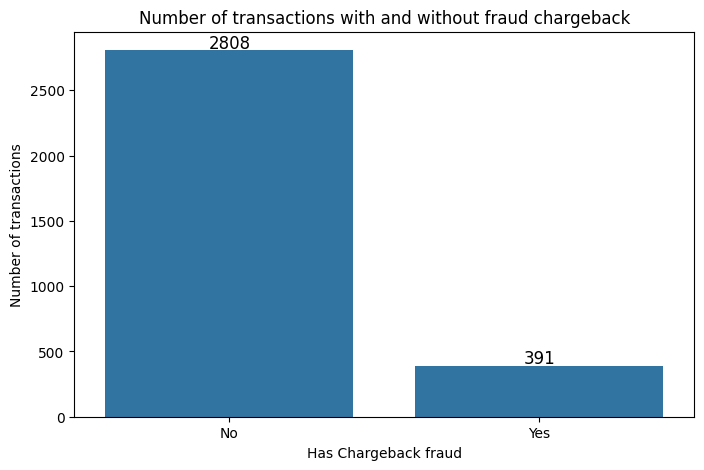

In [9]:
print(data['has_cbk'].value_counts())

fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(x=data['has_cbk'], y=data['has_cbk'].value_counts())

plt.title('Number of transactions with and without fraud chargeback')
plt.ylabel('Number of transactions')
plt.xlabel('Has Chargeback fraud')

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# Adding the number of transactions in each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

In [10]:
# checking for unique values in identification columns
for col in ['merchant_id', 'user_id', 'device_id']:
    print(f"{col}: {data[col].nunique()} unique values.")

merchant_id: 1756 unique values.
user_id: 2704 unique values.
device_id: 1996 unique values.


#### Statistical Analysis

**`transaction_amount` Summary statisticas**:

* **Count**: The dataset contains **3199** transactions
* **Mean**: The average transaction amount is **$767.81**
* **Std dev**: A high standard deviation (**$889.10**) indicates significant variability in transaction amounts.
* **Min**: The smallest transaction recorded is **$1.22**
* **25% (First Quartile)**: 25% of transactions are below **$205.23**.
* **50% (Median)**: The middle transaction amount is **$415.94**.
* **75% (Third Quartile)**: 75% of transactions are below **$981.68**.
* **Max**: The largest transaction recorded is **$4097.21**.

In [11]:
print(data['transaction_amount'].describe()) # Taking a look at the basic statistics of the transaction amount column

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64


**Correlations**

The heatmap bellow visualizes the correlation between various features in the dataset. Here are the key insights:

- **`transaction_date` has a strong negative correlation (-0.94) with `transaction_id`**  
  This likely suggests that `transaction_id` is sequential and increases over time, leading to an inverse relationship with transaction dates.  
  **This is not so relevant for us**, as it does not provide meaningful insights into chargeback fraud.

- **`has_cbk` (chargeback indicator) has the highest correlation with `transaction_amount` (0.29)**  
  Fraudulent transactions tend to have higher amounts, which aligns with our previous findings that fraud-related transactions have a higher mean value.  
  **This is highly relevant, as it suggests that high-value transactions may have a greater likelihood of being fraudulent.**

- **Other features have weak correlations with each other**  
  Most values are close to 0, indicating little to no linear relationship between these variables.  
  **This is not very relevant, as weak correlations suggest these features do not directly impact chargeback fraud detection.**

- **Slight positive correlation (0.11) between `transaction_date` and `has_cbk`**  
  This may suggest that fraud patterns fluctuate over time, but further investigation is needed.  
  **This could be relevant depending on whether fraud occurs more frequently at certain times. It may indicate seasonality in fraudulent transactions.**

- **Minimal correlation between `device_id` and fraud occurrence (-0.05)**  
  This suggests that the device used for the transaction is not a strong fraud indicator in this dataset.  
  **This is not relevant for our analysis, as device information does not seem to help in detecting chargeback fraud.**


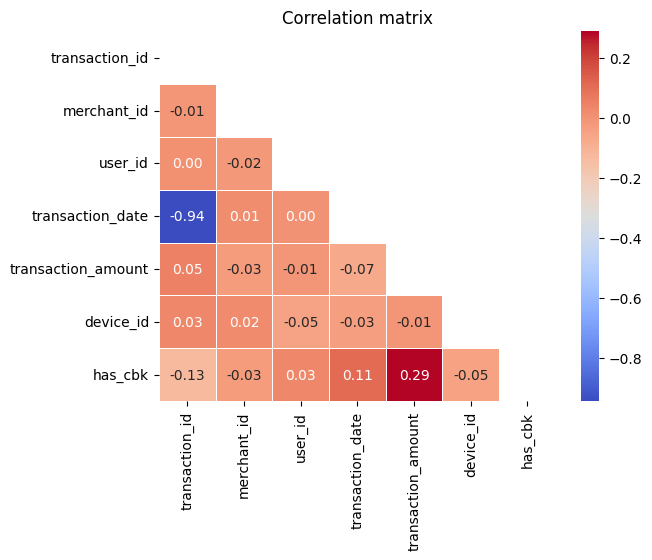

In [12]:
sns.heatmap(
    data.drop(columns=['card_number']).corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    mask=np.triu(data.drop(columns=['card_number']).corr())
)

plt.title('Correlation matrix')

plt.show()

#### Distribution and pattern analysis

##### Diving deeper: **`transaction_amount`**

**Mean comparison**: Comparison of the mean transaction amount across all transactions, as well as segmented by fraudulent and non-fraudulent transactions.

```
All transactions: 767.813
Non-fraudulent transactions: 672.324
Fraudulent transactions: 1453.572
```
**Key Insights**:
* Fraudulent transactions have a significantly higher mean transaction amount (**$1453.57**) compared to non-fraudulent transactions (**$672.32**).
* The overall mean transaction amount is **$767.81**, indicating that fraud cases may be skewing the overall average upwards.

**Median comparison**: Comparison of median transaction amount accross all transactions, fraudulent, and non-fraudulent transactions.

```
All transactions: 415.94
Non-fraudulent transactions: 360.315
Fraudulent transactions: 999.47
```
**Key Insights**:
* The median transaction amount for fraudulent transactions (**$999.47**) is much higher than for non-fraudulent transactions (**$360.32**), reinforcing the pattern seen in the mean comparison.
* The overall median transaction amount is (**$415.94**), which is lower than the mean, suggesting a right-skewed distribution.


**Standard Deviation comparison**: Comparison of standard deviation accross all transactions, fraudulent, and non-fraudulent transactions.

```
All transactions: 889.096
Non-fraudulent transactions: 797.464
Fraudulent transactions: 1169.491
```
**Key Insights**:
* Fraudulent transactions exhibit a much higher standard deviation (**$1169.49**), indicating greater variability in fraudulent transaction amounts.
* Non-fraudulent transactions have a lower standard deviation (**$797.46**), suggesting more consistency in legitimate spending patterns.
* The overall standard deviation is **$889.10**, again reflecting the impact of fraudulent transactions on the dataset's variability.

**Possible suspicious behaviours:**
* Fraudulent transactions tend to have higher amounts.
* High variability may indicate attempts to avoid predictable patterns, making automated detection more challenging.

In [13]:
fraudulent_transactions = data[data['has_cbk']==True]
non_fraudulent_transactions = data[data['has_cbk']==False]

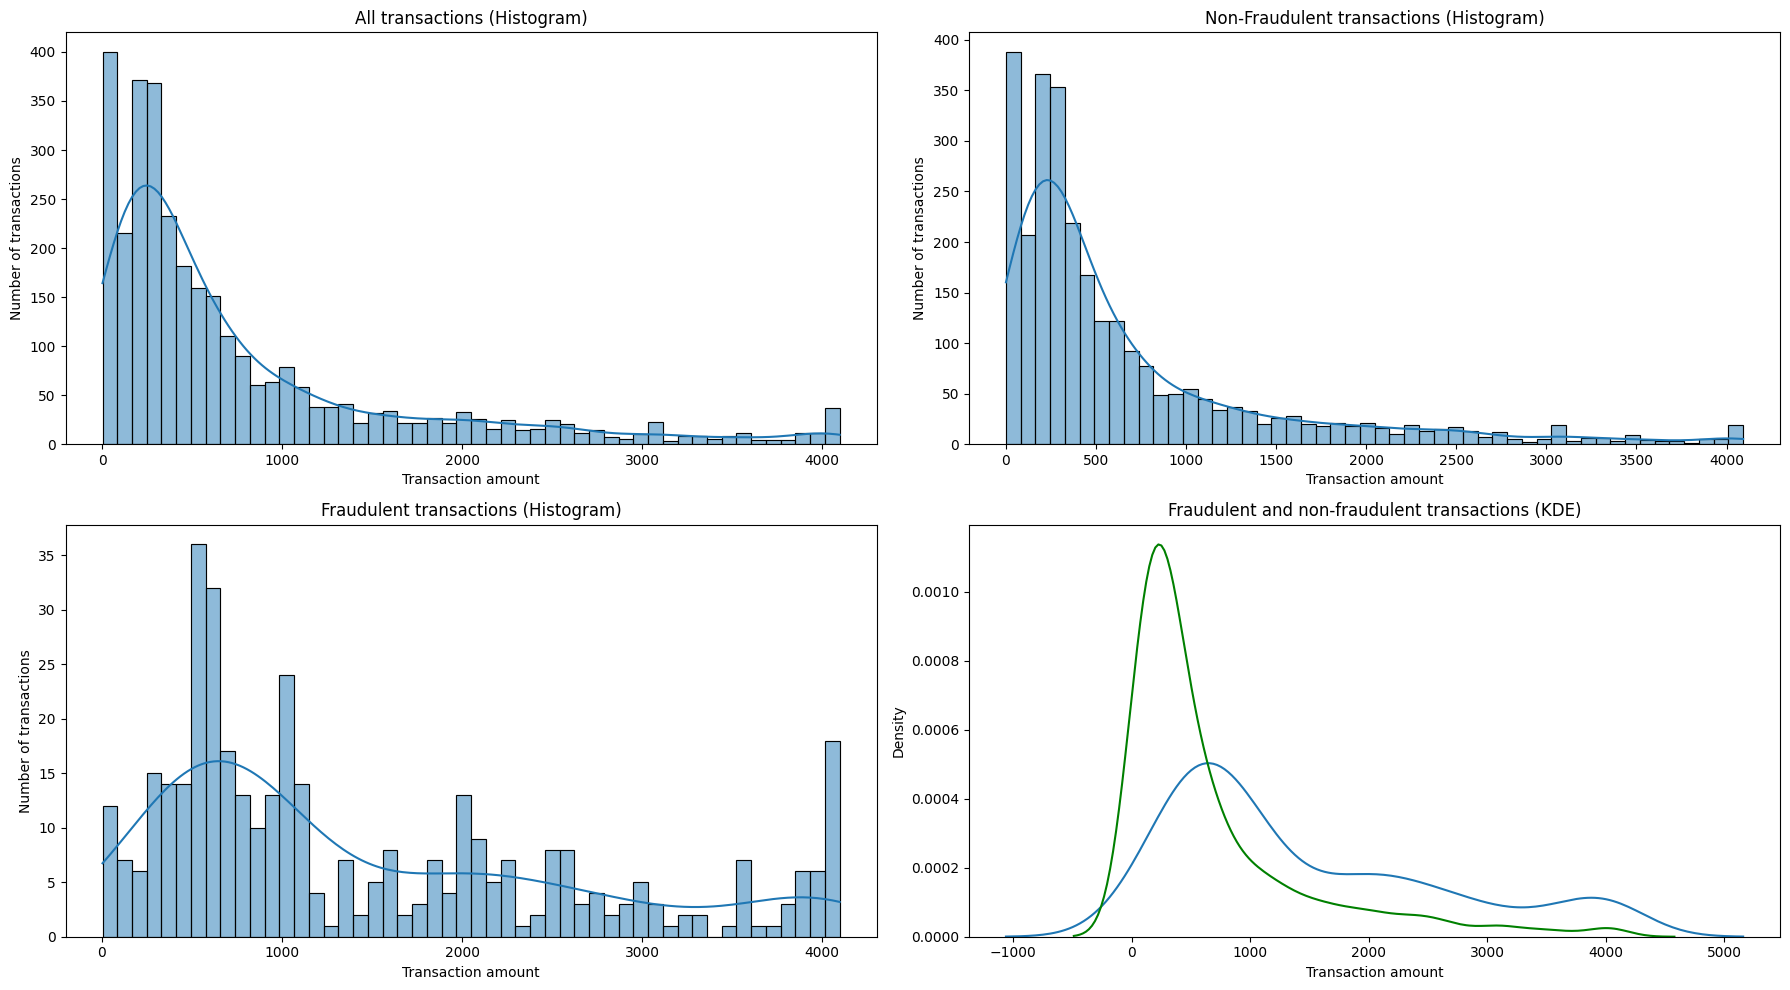

In [14]:
# Creating a function to plot the distribution of the transaction amount
def plot_transaction_amount_dist(data, ax=None, figsize=(8, 5), type='hist', color=None):
    if type == 'hist':
        sns.histplot(data['transaction_amount'], bins=50, kde=True, ax=ax, color=color)
    elif type == 'kde':
        sns.kdeplot(data['transaction_amount'], ax=ax, color=color)


    #sns.histplot(data['transaction_amount'], bins=50, kde=True, ax=ax)

# Plotting the distribution of the transaction amount
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plotting the distribution of the transaction amount for all transactions
plot_transaction_amount_dist(data, ax=axes[0, 0])
axes[0, 0].set_title("All transactions (Histogram)")
axes[0, 0].set_xlabel("Transaction amount")
axes[0, 0].set_ylabel("Number of transactions")

# Plotting the distribution of the transaction amount for non-fraudulent transactions
plot_transaction_amount_dist(non_fraudulent_transactions, ax=axes[0, 1])
axes[0, 1].set_title("Non-Fraudulent transactions (Histogram)")
axes[0, 1].set_xlabel("Transaction amount")
axes[0, 1].set_ylabel("Number of transactions")

# Plotting the distribution of the transaction amount for fraudulent transactions
plot_transaction_amount_dist(fraudulent_transactions, ax=axes[1, 0])
axes[1, 0].set_title("Fraudulent transactions (Histogram)")
axes[1, 0].set_xlabel("Transaction amount")
axes[1, 0].set_ylabel("Number of transactions")

plot_transaction_amount_dist(fraudulent_transactions, ax=axes[1, 1], type='kde')
plot_transaction_amount_dist(non_fraudulent_transactions, ax=axes[1, 1], type='kde', color='green')
axes[1, 1].set_title("Fraudulent and non-fraudulent transactions (KDE)")
axes[1, 1].set_xlabel("Transaction amount")
axes[1, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [15]:
# Getting some statistics about the fraudulent transactions
print("Mean comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(data['transaction_amount'].mean(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].mean(), 3)}")
print(f"Fraudulent transactions: {round(fraudulent_transactions['transaction_amount'].mean(), 3)}")

print("-"*100)

print("Standard deviation comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(data['transaction_amount'].std(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].std(), 3)}")
print(f"Fraudulent transactions: {round(fraudulent_transactions['transaction_amount'].std(), 3)}")

print("-"*100)

print("Median comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(data['transaction_amount'].median(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].median(), 3)}")
print(f"Fraudulent transactions: {round(fraudulent_transactions['transaction_amount'].median(), 3)}")

Mean comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 767.813
Non-fraudulent transactions: 672.324
Fraudulent transactions: 1453.572
----------------------------------------------------------------------------------------------------
Standard deviation comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 889.096
Non-fraudulent transactions: 797.464
Fraudulent transactions: 1169.491
----------------------------------------------------------------------------------------------------
Median comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 415.94
Non-fraudulent transactions: 360.315
Fraudulent transactions: 999.47


##### Diving deeper:  **`user_id`**, **`merchant_id`** and **`device_id`**

##### Users analysis

**Top 3** users with the most total transactions

```
User ID: 11750 - Transactions: 31
User ID: 91637 - Transactions: 22
User ID: 79054 - Transactions: 17
```

**Top 3** users with the most fraudulent transactions
```
User ID: 11750 - Fraudulent transactions: 25
User ID: 91637 - Fraudulent transactions: 19
User ID: 79054 - Fraudulent transactions: 15
```
**Key Insights:**
* The user with the most transactions (11750) also has the highest number of fraudulent transactions (25), suggesting suspicious activity.
* Users 91637 and 79054 follow a similar trend, with 19 and 15 fraudulent transactions, respectively.
* Fraudulent transactions appear concentrated among certain users, which could indicate organized fraudulent behavior.

**Top 3** users with the highest fraud rate (that isn't 100%)
```
User ID: 78262 - Fraud rate: 0.92 - Total transactions: 13
User ID: 79054 - Fraud rate: 0.88 - Total transactions: 17
User ID: 91637 - Fraud rate: 0.86 - Total transactions: 22
```
**Key Insights:**
* 120 users have 100% fraudulent transactions
* Users 78262, 79054 and 91637 has an extremely high fraud rate (92%, 88% and 86% respectively), indicating potential fraudsters.
* A high fraud rate in combination with a high number of transactions could be a strong indicator of fraudulent activity.

**Possible suspicious patterns:**
* Some fraudsters are repeat offenders and tend to make a high number of transactions.
* The results suggest that fraudsters tend to carry out multiple transactions in a sequence (It is possible that fraudsters are testing cards or making small transactions before conducting larger ones).

**Recommendations:**
* Check the user's fraud history. If the user has a record of one or more fraudulent transactions, we should monitor them closely.
* Be cautious of multiple transactions in a sequence. Consider implementing security measures to temporarily block users after 3 or more transactions within a short period of time.

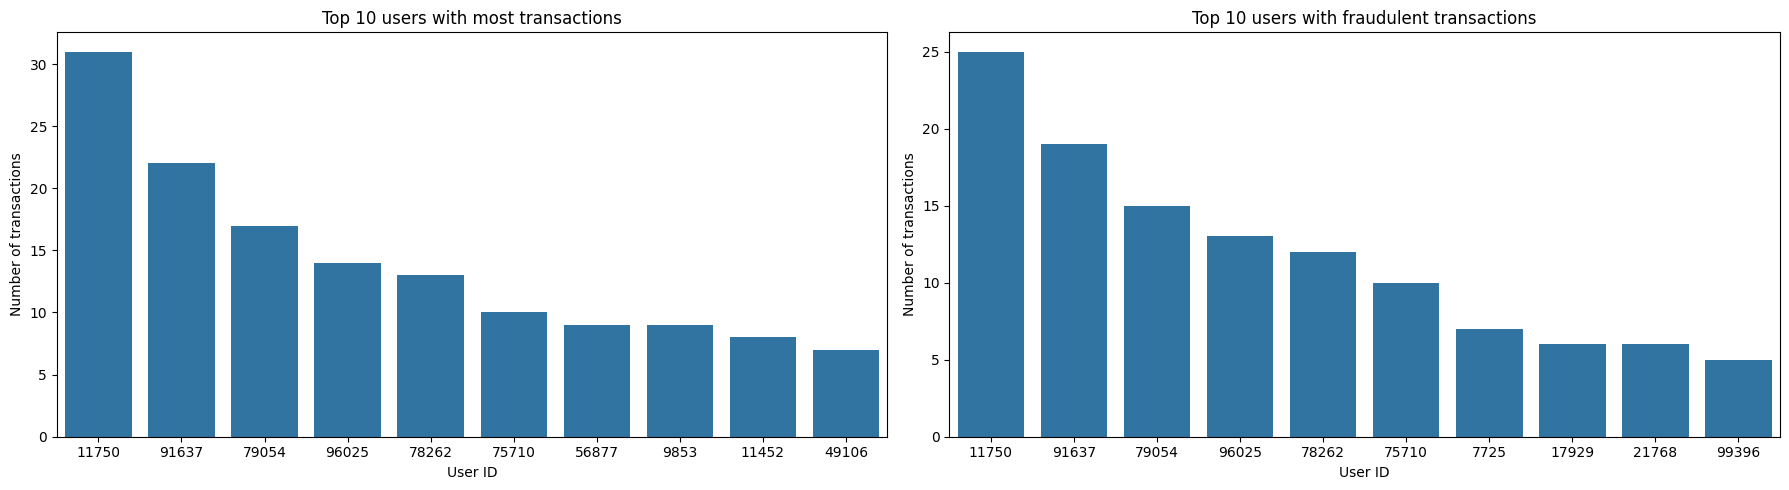

In [16]:
users = data['user_id'].value_counts().sort_values(ascending=False)
users_fraud = fraudulent_transactions['user_id'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(x=users.head(10).index, y=users.head(10).values, order=users.head(10).index, ax=axes[0])
axes[0].set_title("Top 10 users with most transactions")
axes[0].set_xlabel("User ID")
axes[0].set_ylabel("Number of transactions")

sns.barplot(x=users_fraud.head(10).index, y=users_fraud.head(10).values, order=users_fraud.head(10).index, ax=axes[1])
axes[1].set_title("Top 10 users with fraudulent transactions")
axes[1].set_xlabel("User ID")
axes[1].set_ylabel("Number of transactions")

plt.tight_layout()
plt.show()

##### 

In [17]:
users_fraud = fraudulent_transactions['user_id'].value_counts().sort_values(ascending=False)

print("Top 3 users with more transactions:")
for i, j in zip(users.index[:3], users.values[:3]):
    print(f"User ID: {i} - Number of transactions: {j}")

print("-"*50)

print("Top 3 users with more fraudulent transactions:")
for i, j in zip(users_fraud.index[:3], users_fraud.values[:3]):
    print(f"User ID: {i} - Number of fraudulent transactions: {j}")

Top 3 users with more transactions:
User ID: 11750 - Number of transactions: 31
User ID: 91637 - Number of transactions: 22
User ID: 79054 - Number of transactions: 17
--------------------------------------------------
Top 3 users with more fraudulent transactions:
User ID: 11750 - Number of fraudulent transactions: 25
User ID: 91637 - Number of fraudulent transactions: 19
User ID: 79054 - Number of fraudulent transactions: 15


In [18]:
# Creating a new dataframe with the number of transactions and the number of fraudulent transactions for each user
users_transactions = users.to_frame().merge(users_fraud.to_frame().reset_index(), on='user_id', how='left').fillna(0).rename(columns={
    'index': 'user_id', 'count_x': 'total_transactions', 'count_y': 'fraud'
    })

users_transactions['fraud'] = users_transactions['fraud'].astype(int)

# Calculating the fraud rate for each user
users_transactions['fraud_rate'] = users_transactions['fraud'] / users_transactions['total_transactions']
users_transactions.sort_values(by='fraud_rate', ascending=False, inplace=True)

# Total number of users that all transactions are fraudulent
print(f"Users with only fraudulent transactions: {len(users_transactions[users_transactions['fraud_rate'] == 1])}")

Users with only fraudulent transactions: 120


In [19]:
not_100 = users_transactions[users_transactions['fraud_rate'] != 1]

for i in range(1, 4):
    print(f"User ID: {not_100.iloc[i]['user_id']} - Fraud rate: {not_100.iloc[i]['fraud_rate']:.2f} - Total transactions: {not_100.iloc[i]['total_transactions']}")

User ID: 78262.0 - Fraud rate: 0.92 - Total transactions: 13.0
User ID: 79054.0 - Fraud rate: 0.88 - Total transactions: 17.0
User ID: 91637.0 - Fraud rate: 0.86 - Total transactions: 22.0


In [20]:
not_100 = not_100.head(10)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding the bar for the total transactions
fig.add_trace(
    go.Bar(
        x=not_100['user_id'],
        y=not_100['total_transactions'],
        name='Total',
        marker_color='blue',
        hovertemplate='Total Transactions: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the bar for the fraudulent transactions
fig.add_trace(
    go.Bar(
        x=not_100['user_id'],
        y=not_100['fraud'],
        name='Fraud',
        marker_color='orange',
        hovertemplate='Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the line for the fraud rate
fig.add_trace(
    go.Scatter(
        x=not_100['user_id'],
        y=not_100['fraud_rate'],
        name='Fraud Rate',
        mode='lines+markers',
        line=dict(color='red'),
        hovertemplate='Fraud Rate: %{y}<extra></extra>',
    ),
    secondary_y=True,
)

# Layout configuration
fig.update_layout(
    title="Total Transactions vs Fraud Transactions per User",
    xaxis_title="User ID",
    yaxis_title="Number of Transactions",
    yaxis2_title="Fraud Rate",
    barmode='group',
    legend=dict(
        x=0.98,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.5)',
    ),
    template="plotly_white",
    width=1000,
    height=400,
)

# Axis configuration
fig.update_xaxes(
    tickangle=45,
    type='category',
)
fig.show()

In [21]:
sequential_transactions = data.copy()

# Converter a coluna de data para o tipo datetime
sequential_transactions['transaction_date'] = pd.to_datetime(sequential_transactions['transaction_date'])

# Ordenar o DataFrame por user_id e transaction_date
sequential_transactions = sequential_transactions.sort_values(by=['user_id', 'transaction_date'])

# Calcular a diferença de tempo entre transações consecutivas para cada usuário
sequential_transactions['time_diff'] = sequential_transactions.groupby('user_id')['transaction_date'].diff().abs()

time_threshold = pd.Timedelta(minutes=15)

sequential_transactions['is_sequential'] = sequential_transactions['time_diff'] <= time_threshold

result = sequential_transactions.groupby('user_id').agg(
    total_transactions=('transaction_id', 'size'),
    sequential_transactions=('is_sequential', 'sum'),
    total_amount=('transaction_amount', 'sum'),
    has_cbk_any=('has_cbk', 'any'),
    has_cbk_all=('has_cbk', 'all')
).reset_index()

prop_any = [float(result[result['sequential_transactions'] > i]['has_cbk_any'].value_counts(normalize=True).iloc[0]) for i in range(0, max(result['sequential_transactions']))]

prop_all = [float(result[result['sequential_transactions'] > i]['has_cbk_all'].value_counts(normalize=True).iloc[0]) for i in range(0, max(result['sequential_transactions']))]

print("Proportion of any fraudulent transaction in a sequence of transactions from the same user:")
for i, p in enumerate(prop_any):
    print(f"{i+1}: {p:.2f}")

print("-"*90)

print("Proportion of all fraudulent transaction in a sequence of transactions from the same user:")
for i, p in enumerate(prop_all):
    print(f"{i+1}: {p:.2f}")


Proportion of any fraudulent transaction in a sequence of transactions from the same user:
1: 0.51
2: 0.81
3: 1.00
4: 1.00
5: 1.00
6: 1.00
------------------------------------------------------------------------------------------
Proportion of all fraudulent transaction in a sequence of transactions from the same user:
1: 0.70
2: 0.57
3: 0.62
4: 0.67
5: 0.67
6: 0.50


##### Merchant Analysis

**Top 3** merchants with the most total transactions

```
Merchant ID: 49205 - Transactions: 73
Merchant ID: 17275 - Transactions: 30
Merchant ID: 4705 - Transactions: 22
```

**Top 3** merchants with the most fraudulent transactions
```
Merchant ID: 17275 - Fraudulent transactions: 22
Merchant ID: 4705 - Fraudulent transactions: 19
Merchant ID: 1308 - Fraudulent transactions: 15
```
**Key Insights:**
* Merchant 49205 stands out with the highest number of transactions (73), but doesn't appear to have the highest fraud rate.
* Merchant 17275, although having the second most transactions (30), has the highest number of fraudulent transactions (22), signaling a potential fraud issue.
* The fraudulent activity is concentrated among a small number of merchants, suggesting that specific merchants may need closer monitoring. 

**Top 3** merchants with the highest fraud rate (that isn't 100%)
```
Merchant ID: 49919.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 66876.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 77130.0 - Fraud rate: 0.87 - Total transactions: 15.0
```
**Key Insights:**
* **66** merchants have 100% of fraudulent transactions
* Merchants 49919 and 66876 have an exceptionally high fraud rate (88%), despite having relatively few transactions (8), which raises red flags for potential fraudulent behavior.
* Merchant 77130, with a fraud rate of 87%, also shows a significant level of suspicious activity with 15 total transactions.
* A high fraud rate coupled with a relatively low number of transactions may suggest targeted fraudulent behavior or vulnerability.

**Possible suspicious patterns:**
* High-value transactions, especially when significantly deviating from the merchant’s average (e.g., exceeding **two standard deviations** from the mean transaction value). 
* Merchants with a high fraud ratio may be actively involved in fraudulent schemes or failing to prevent fraudulent activities.  

**Recommendations:**
* Increase monitoring and due diligence for merchants with high fraudulent transaction volumes, such as Merchant 17275 and 4705.
* Investigate merchants with a high fraud ratio and low transaction count, as they may be involved in targeted fraudulent schemes.

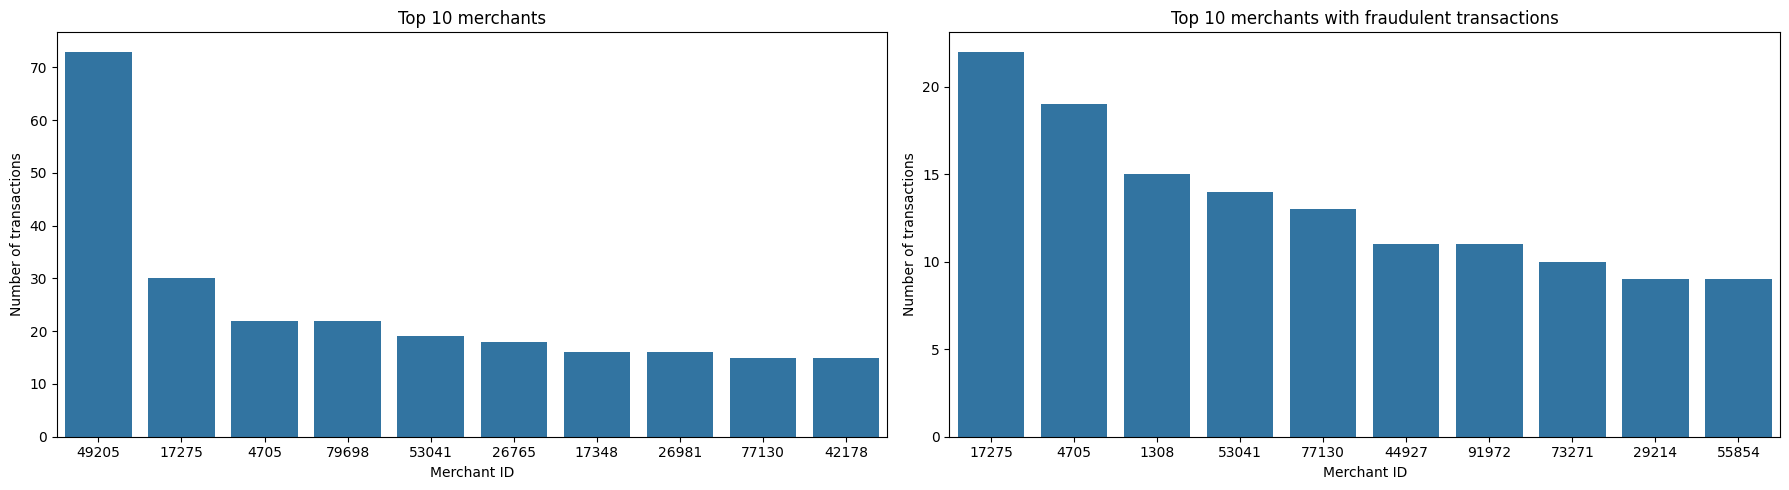

In [22]:
merchants = data['merchant_id'].value_counts().sort_values(ascending=False)
merchants_fraud = fraudulent_transactions['merchant_id'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(x=merchants.head(10).index, y=merchants.head(10).values, order=merchants.head(10).index, ax=axes[0])
axes[0].set_title("Top 10 merchants")
axes[0].set_xlabel("Merchant ID")
axes[0].set_ylabel("Number of transactions")

sns.barplot(x=merchants_fraud.head(10).index, y=merchants_fraud.head(10).values, order=merchants_fraud.head(10).index, ax=axes[1])
axes[1].set_title("Top 10 merchants with fraudulent transactions")
axes[1].set_xlabel("Merchant ID")
axes[1].set_ylabel("Number of transactions")

fig.tight_layout()
plt.show()

In [23]:
print("Top 3 merchants with more transactions:")
for i, j in zip(merchants.index[:3], merchants.values[:3]):
    print(f"Merchant ID: {i} - Number of transactions: {j}")

print("-"*50)

print("Top 3 merchants with more fraudulent transactions:")
for i, j in zip(merchants_fraud.index[:3], merchants_fraud.values[:3]):
    print(f"Merchant ID: {i} - Number of fraudulent transactions: {j}")

Top 3 merchants with more transactions:
Merchant ID: 49205 - Number of transactions: 73
Merchant ID: 17275 - Number of transactions: 30
Merchant ID: 4705 - Number of transactions: 22
--------------------------------------------------
Top 3 merchants with more fraudulent transactions:
Merchant ID: 17275 - Number of fraudulent transactions: 22
Merchant ID: 4705 - Number of fraudulent transactions: 19
Merchant ID: 1308 - Number of fraudulent transactions: 15


In [24]:
merchants_transactions = merchants.to_frame().merge(merchants_fraud.to_frame().reset_index(), on='merchant_id', how='left').fillna(0).rename(columns={
    'index': 'merchant_id', 'count_x': 'total_transactions', 'count_y': 'fraud'
    })

merchants_transactions['fraud'] = merchants_transactions['fraud'].astype(int)

merchants_transactions['fraud_rate'] = merchants_transactions['fraud'] / merchants_transactions['total_transactions']

merchants_transactions.sort_values(by='fraud_rate', ascending=False, inplace=True)

print(f"Merchants with only fraudulent transactions: {len(merchants_transactions[merchants_transactions['fraud_rate'] == 1])}")

Merchants with only fraudulent transactions: 66


In [25]:
not_100_merchants = merchants_transactions[merchants_transactions['fraud_rate'] != 1]

for i in range(1, 4):
    print(f"Merchant ID: {not_100_merchants.iloc[i]['merchant_id']} - Fraud rate: {not_100_merchants.iloc[i]['fraud_rate']:.2f} - Total transactions: {not_100_merchants.iloc[i]['total_transactions']}")

Merchant ID: 49919.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 66876.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 77130.0 - Fraud rate: 0.87 - Total transactions: 15.0


In [26]:
not_100_merchants = not_100_merchants.head(10)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding the bar for the total transactions
fig.add_trace(
    go.Bar(
        x=not_100_merchants['merchant_id'],
        y=not_100_merchants['total_transactions'],
        name='Total',
        marker_color='blue',
        hovertemplate='Total Transactions: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the bar for the fraudulent transactions
fig.add_trace(
    go.Bar(
        x=not_100_merchants['merchant_id'],
        y=not_100_merchants['fraud'],
        name='Fraud',
        marker_color='orange',
        hovertemplate='Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the line for the fraud rate
fig.add_trace(
    go.Scatter(
        x=not_100_merchants['merchant_id'],
        y=not_100_merchants['fraud_rate'],
        name='Fraud Rate',
        mode='lines+markers',
        line=dict(color='red'),
        hovertemplate='Fraud Rate: %{y}<extra></extra>',
    ),
    secondary_y=True,
)

# Layout configuration
fig.update_layout(
    title="Total Transactions vs Fraud Transactions per Merchant",
    xaxis_title="Merchant ID",
    yaxis_title="Number of Transactions",
    yaxis2_title="Fraud Rate",
    barmode='group',
    legend=dict(
        x=0.98,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.5)',
    ),
    template="plotly_white",
    width=1000,
    height=400,
)

# Axis configuration
fig.update_xaxes(
    tickangle=45,
    type='category',
)
fig.show()

In [27]:
# Calculating the sum transaction amount for each merchant
merchants_amout = data.groupby('merchant_id')['transaction_amount'].mean()
full_merchants = merchants_transactions.merge(merchants_amout.to_frame().reset_index(), on='merchant_id', how='left')
full_merchants.sort_values(by='fraud', ascending=False, inplace=True)

In [28]:
# Creating a scatter plot with the number of transactions, number of frauds, fraud rate and transaction amount for each merchant
fig = px.scatter(
    full_merchants,
    x='total_transactions',
    y='fraud',
    size='fraud_rate',
    color='transaction_amount',
    size_max=30,
    color_continuous_scale='viridis',
    title='Transactions vs Frauds per Merchant',
    labels={
        'total_transactions': 'Count of transactions',
        'fraud': 'Count of frauds',
        'fraud_rate': 'Fraud Rate',
        'transaction_amount': 'Mean Amount'
    }
)

# Adding the merchant ID in the hover
fig.update_layout(
    xaxis_title='Count of transactions',
    yaxis_title='Count of frauds',
    title_font_size=20,
    title_x=0.5,
    hovermode='closest',
    template='plotly_white',
    width=1000,
    height=400,
)

fig.update_xaxes(range=[-3, 35])
fig.update_yaxes(range=[-2, 30])

fig.add_annotation(
    x=30, y=30,  # Posição aproximada da anotação no gráfico
    text="Bubble size represents Fraud Rate",
    showarrow=False,
    font=dict(size=12),
    bgcolor="white",
    bordercolor="black",
    borderwidth=1
)

fig.show()

##### Device Analysis

**1. Unique users != Unique devices**

```
Unique devices: 1996
Unique users: 1968
```

Since the number of devices is greater than the number of users, some users are using more than one device. It's a potencial flag?

**Users with more than one device**
* **24** users have more than one device.
* These users represent **1.22%** of the total user base (**24/1968**).
* The fraud proportion among these users is **54.17%**, which is extremely high.
* Insight: Users with multiple devices are significantly more likely to be involved in fraudulent activities.

**Users with only one device**
* **1944** users have only one device.
* These users represent **98.78%** of the total user base (**1944/1968**).
* The fraud proportion among these users is **5.5%**, which is relatively low.
* Insight: The vast majority of users with a single device exhibit normal behavior, with a low incidence of fraud.

**Possible explanations:**
* **Device sharing:** Users with multiple devices may be sharing accounts or devices with others, increasing the risk of fraudulent activities.
* **Organized fraud:** Users with multiple devices may be involved in organized fraud schemes, where multiple devices are used to carry out fraudulent transactions.
* **Legitimate use:** Although less likely, some users may have legitimate reasons for using multiple devices (e.g., personal and corporate devices).

**Recommendations:**
* Rigorous monitoring: Users with multiple devices should be closely monitored, given the high fraud proportion in this group.
* Additional verification: Implement additional checks (such as two-factor authentication) for users who use more than one device.

**2. Missing values:**
As mentioned earlier, we have some missing values related to **`device_id`**. Let's investigate whether this could indicate suspicious behavior.

Let's perform a hypothesis test:

* Null Hypothesis (H₀): "There is no difference in the proportion of frauds between the two groups"

* Alternative Hypothesis (H₁): "There is a difference in the proportion of frauds between the two groups"

* Group 1 (No device info): 
  - Size: 830
  - Frauds: 67

* Group 2 (Device info):
  - Size: 2369
  - 324

* Results:
  - Z-Statistic: -4.2420
  - P-Value: 0.0000

**Key Insights:**
* The p-value obtained is 0.0000, which is less than the significance level of 0.05. This allows us to reject the null hypothesis.
* We conclude that there is a statistically significant difference in the proportion of fraudulent transactions between the two groups.

In [29]:
device_transaction_count = data.groupby('device_id').size().reset_index(name='total_transactions')
device_owner = data.groupby(['device_id', 'user_id']).size().reset_index(name='count')

fraudulent_transactions_per_device = device_transaction_count.loc[data['has_cbk'] == True]
fraudulent_device_count = fraudulent_transactions_per_device.groupby('device_id').size().reset_index(name='fraudulent_transactions')

device_analysis = pd.merge(device_transaction_count, fraudulent_device_count, on='device_id', how='left')
device_analysis['fraudulent_transactions'] = device_analysis['fraudulent_transactions'].fillna(0)

# Ordenar por total de transações
most_active_devices = device_analysis.sort_values(by='total_transactions', ascending=False)

# Ordenar por transações fraudulentas
most_fraudulent_devices = device_analysis.sort_values(by='fraudulent_transactions', ascending=False)

print(f"Unique devices: {device_owner['device_id'].nunique()}")
print(f"Unique users: {device_owner['user_id'].nunique() }")

Unique devices: 1996
Unique users: 1968


In [30]:
# Grouping the data by user_id and counting the number of unique devices
user_device_count = data.groupby('user_id')['device_id'].nunique().reset_index(name='num_devices')

# Filtering the users with more than one device
users_with_multiple_devices = user_device_count[user_device_count['num_devices'] > 1]
users_with_one_device = user_device_count[user_device_count['num_devices'] == 1]

# Verifying if the user has at least one fraudulent transaction
user_has_cbk = data.groupby('user_id')['has_cbk'].any().reset_index(name='has_any_cbk')

# Merging the data to verify if the user has at least one fraudulent transaction
users_with_multiple_devices = pd.merge(
    users_with_multiple_devices,
    user_has_cbk,
    on='user_id',
    how='left'
)

users_with_one_device = pd.merge(
    users_with_one_device,
    user_has_cbk,
    on='user_id',
    how='left'
)

In [31]:
len(users_with_multiple_devices), len(users_with_one_device)

(24, 1944)

In [69]:
proportion_multiple_devices = users_with_multiple_devices['has_any_cbk'].value_counts(normalize=True)
proportion_one_device = users_with_one_device['has_any_cbk'].value_counts(normalize=True)
proportion_multiple_devices, proportion_one_device

(has_any_cbk
 True     0.541667
 False    0.458333
 Name: proportion, dtype: float64,
 has_any_cbk
 False    0.944444
 True     0.055556
 Name: proportion, dtype: float64)

In [33]:
# Grouping the data by device_id and counting the number of unique users
device_user_count = data.groupby('device_id')['user_id'].nunique().reset_index(name='num_users')

# Filtering devices with more than one user
devices_with_multiple_users = device_user_count[device_user_count['num_users'] > 1]

len(devices_with_multiple_users)

0

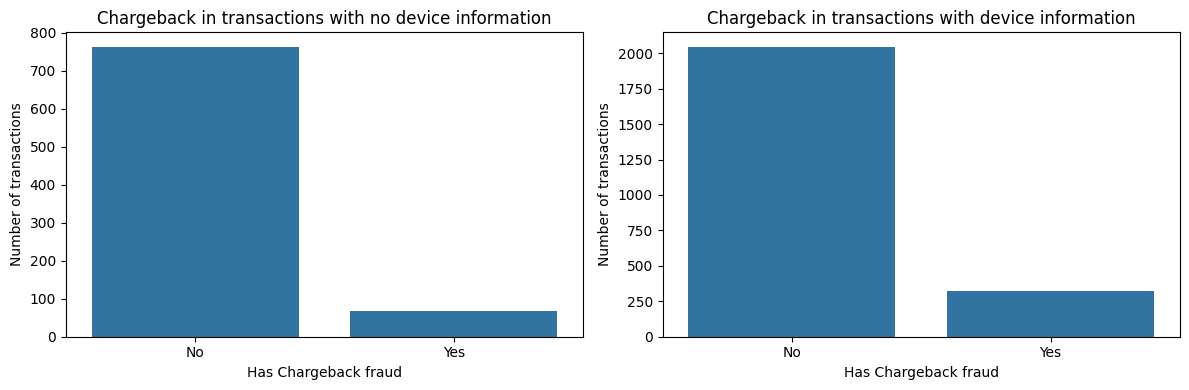

In [90]:

# Checking devices with no information about the device

no_device_info = data[data['device_id'].isna()]
chargeback_counts = no_device_info['has_cbk'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the barplot about the chargeback in transactions with no device information
sns.barplot(
    x=chargeback_counts.index,
    y=chargeback_counts.values,
    ax=ax[0]
)
ax[0].set_title('Chargeback in transactions with no device information')
ax[0].set_ylabel('Number of transactions')
ax[0].set_xlabel('Has Chargeback fraud')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['No', 'Yes'])

# Plotting the barplot about the chargeback in transactions with device information
sns.barplot(
    x=data.dropna()['has_cbk'], y=data.dropna()['has_cbk'].value_counts(), ax=ax[1]
)
ax[1].set_title('Chargeback in transactions with device information')
ax[1].set_ylabel('Number of transactions')
ax[1].set_xlabel('Has Chargeback fraud')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['No', 'Yes'])


fig.tight_layout()
plt.show()

In [87]:
# Group 1 - Transactions with missing device_id
fraud_missing_device = data[data['device_id'].isna()]['has_cbk']
# Group 2 - Transactions with filled device_id
fraud_filled_device = data[data['device_id'].notna()]['has_cbk']

count = [fraud_missing_device.sum(), fraud_filled_device.sum()]
nobs = [len(fraud_missing_device), len(fraud_filled_device)]

print(f"Number of fraudulent transactions with missing device_id: {count[0]}")
print(f"Number of fraudulent transactions with filled device_id: {count[1]}")

print(f"Number of transactions with missing device_id: {nobs[0]}")
print(f"Number of transactions with filled device_id: {nobs[1]}")


# Hypothesis testing
# H0: There is no difference in the proportion of frauds between the two groups
# H1: There is a difference in the proportion of frauds between the two groups

z_stat, p_value = proportions_ztest(count, nobs)

print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation of the p-value
if p_value < 0.05:
    print("Rejection of the null hypothesis: there is enough evidence to say that there is a significant difference.")
else:
    print("Fail to reject the null hypothesis: there is not enough evidence to say that there is a significant difference.")

Number of fraudulent transactions with missing device_id: 67
Number of fraudulent transactions with filled device_id: 324
Number of transactions with missing device_id: 830
Number of transactions with filled device_id: 2369
Z-Statistic: -4.2420
P-Value: 0.0000
Rejection of the null hypothesis: there is enough evidence to say that there is a significant difference.


##### Diving deeper:  **`transaction_date`**

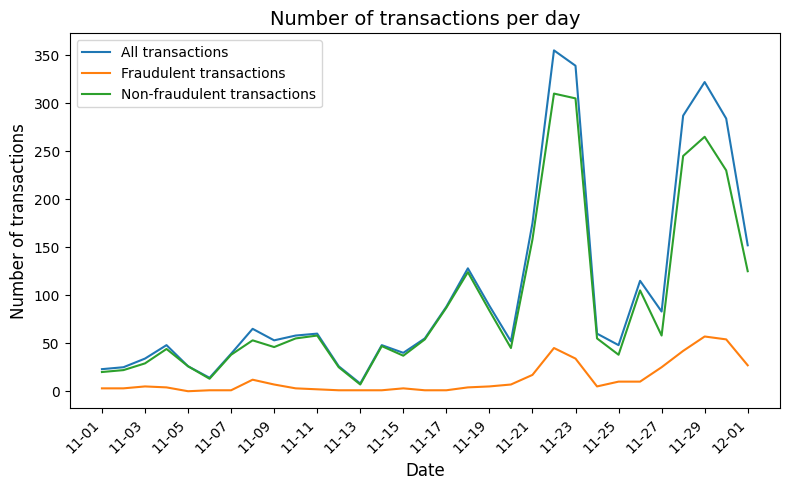

In [29]:
# Number of transactions per day
transaction_per_day = data.set_index('transaction_date').resample('D').count()['transaction_id']
fraudulent_transactions_per_day = fraudulent_transactions.set_index('transaction_date').resample('D').count()['transaction_id']
non_fraudulent_transactions_per_day = non_fraudulent_transactions.set_index('transaction_date').resample('D').count()['transaction_id']

# Plotting the number of transactions per day
plt.figure(figsize=(8, 5))

sns.lineplot(x=transaction_per_day.index, y=transaction_per_day.values, label='All transactions')
sns.lineplot(x=fraudulent_transactions_per_day.index, y=fraudulent_transactions_per_day.values, label='Fraudulent transactions')
sns.lineplot(x=non_fraudulent_transactions_per_day.index, y=non_fraudulent_transactions_per_day.values, label='Non-fraudulent transactions')

plt.title("Number of transactions per day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

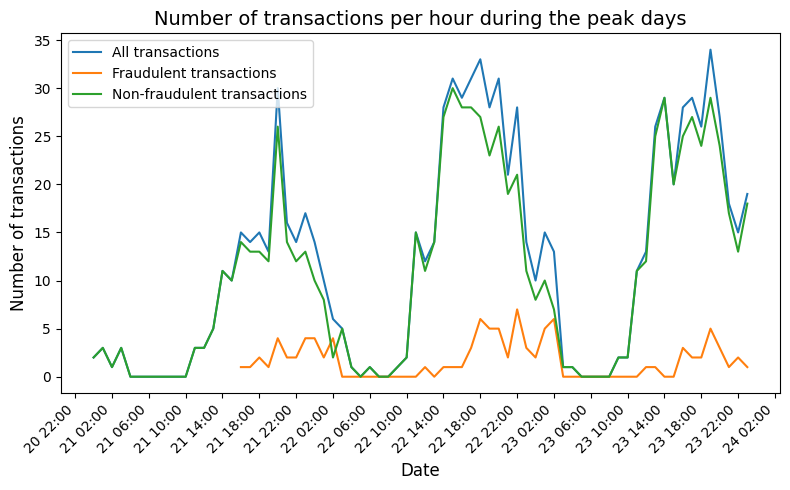

In [30]:
data_peak = data[(data['transaction_date'] >= '2019-11-21') & (data['transaction_date'] <= '2019-11-24')]
fraudulent_data_peak = fraudulent_transactions[(fraudulent_transactions['transaction_date'] >= '2019-11-21') & (fraudulent_transactions['transaction_date'] <= '2019-11-24')]
non_fraudulent_data_peak = non_fraudulent_transactions[(non_fraudulent_transactions['transaction_date'] >= '2019-11-21') & (non_fraudulent_transactions['transaction_date'] <= '2019-11-24')]

# Number of transactions per day
transaction_per_day_peak = data_peak.set_index('transaction_date').resample('h').count()['transaction_id']
fraudulent_transactions_per_day_peak = fraudulent_data_peak.set_index('transaction_date').resample('h').count()['transaction_id']
non_fraudulent_transactions_per_day_peak = non_fraudulent_data_peak.set_index('transaction_date').resample('h').count()['transaction_id']

# Plotting the number of transactions per day
plt.figure(figsize=(8, 5))

sns.lineplot(x=transaction_per_day_peak.index, y=transaction_per_day_peak.values, label='All transactions')
sns.lineplot(x=fraudulent_transactions_per_day_peak.index, y=fraudulent_transactions_per_day_peak.values, label='Fraudulent transactions')
sns.lineplot(x=non_fraudulent_transactions_per_day_peak.index, y=non_fraudulent_transactions_per_day_peak.values, label='Non-fraudulent transactions')

plt.title("Number of transactions per hour during the peak days", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()